# Project Overview

In this project you will take an ordered sequence of images, taken by rotating the camera around the vertical axis, along with manually-defined initial rough alignments, and stitch them into a single cylindrical panoramic image. You will accompilsh this by following the high-level process below:

1. Calibrate your camera (already done for the test images).
2. Reproject the input images into cylindrical coordinates.
3. Use the pyramid-based iterative Lucas Kanade algorithm to compute alignments between each image and the next one in the sequence.
4. Blend the edges of each image with its neighbors both before and after in the sequence.
5. Place the images at their proper positions in the panorama.
6. Correct for any vertical drift caused by imperfect camera rotation.
7. Once you have generated a panorama, you can view it with this panorama viewer page. By default, it shows the test panorama, but you can upload your own image to view.



# Colaboratory Tips

## How to upload files by Colaboratory file browser

Simply use the file browser in the FILES tab in your left pane (click "View"-"Table of contents" menu if you cannot find it).

Also be careful about the lifetime of the uploaded files. They will disappear after several hours when the colab recycles your VM (it happens after a few hours of inactivity or at several hours of VM uptime).

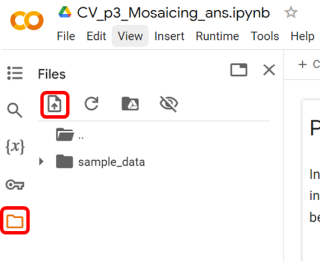

## How to upload multiple files to Colaboratory

1. Select multiple files in "Colab file browser" (see above), or
2. Upload a ZIP file containing all the files you need, and unzip it in Colab VM
   1. Upload a ZIP by Colab file browser (or by `google.colab.files.upload()`)
   2. Use `!` operator in a code cell. For example run `!7z e -y foo.zip` (or `!7z x -y foo.zip` to preserve the directry structure in the zip if needed). Do `REFRESH` in the file browser first to find the extracted files. The cell below shows how to extract files from a zip you uploaded.


In [1]:
#@title Extract files from a ZIP file
ZIP_FILE_NAME = "CV_p3_Mosaicing.zip" #@param {type:"string"}

!7z e -y {ZIP_FILE_NAME}


zsh:1: command not found: 7z


# Numpy/Images Tips

## Rectangular Regions

It is possible to extract and assign to rectangular regions of numpy arrays using slicing (similar to ordinary list slices). If you have an image of shape `(H, W, 3)` and you want to extract the rectangular region from `(x1,y1)` up to `(x2,y2)`, you can do the following (assuming $x2>x1$, $y2>y1$):

```
region = image[y1:y2, x1:x2]
```

Likewise, you may also fill in a region of an image by assigning to a rectangular slice:

```
image[y1:y2, x1:x2] = region
```

The value being assigned must match the shape of the slice you are assigning to. In this case, region must be an array with shape `(y2-y1, x2-x1, 3)` or broadcastable as such.

## Applying Masks

If you have an image with shape `(H, W, 3)`, and a binary mask with shape `(H, W)`, both numpy arrays, you can do some useful things with them.

You can apply the mask to the image by doing

```
masked = image * mask[..., np.newaxis]
```

When mask is a binary image, masked will contain the same values as image except where mask is False, in which case it will have zeros.

If mask is a boolean array (it must have dtype `bool`, it is not enough that mask only contains `1`s and `0`s), you can also use it to pull out all pixels in the array where the mask is `True`/`1`. If mask has $N$ `True`/`1` pixels in it, doing the following:

```
pixels = image[mask]
```

will give you an `(N, 3)` array pixels that contains the RGB pixel values from image wherever the mask is `True`.

## Flattening/Reducing Masks

If you have a 3D multi-channel boolean mask with shape `(H, W, C)` and you want to reduce it to a 2D mask, you can do

```
reduced = np.any(mask, axis=-1) # (reduction with OR)
reduced = np.all(mask, axis=-1) # (reduction with AND)
```

to OR/AND all of the values on the last axis together into a single value.


# Skeleton

Your grade will be based on code that you add to complete the skeleton cell below. Though it should not be necessary, you are free to write additional functions as you see fit to complete the assignment. You are not, however, allowed to import additional libraries or submit separate code files. Everything you will need has been included in the skeleton.

For convolution, **you may use the pre-included `scipy.ndimage.filters.convolve` function. Make sure to read its documentation.** The cells below named `mosaic.py`, `calibrate_camera.py`, and `make_cylindrical.py`  can be used to run the skeleton on a set of images. Usage is described below.

All image parameters for skeleton functions are passed as 3D numpy arrays with shape `(height, width, 3)` for color images. **You should return images in the same format.**



In [47]:
import pickle
import numpy as np
from scipy.ndimage import convolve as conv

#import cv2 #only for debugging

def bilinear_interp(image, points):
    """Given an image and an array of row/col (Y/X) points, perform bilinear
    interpolation and return the pixel values in the image at those points."""
    points = np.asarray(points)
    if points.ndim == 1:
        points = points[np.newaxis]

    valid = np.all(points < [image.shape[0]-1, image.shape[1]-1], axis=-1)
    valid *= np.all(points >= 0, axis=-1)
    valid = valid.astype(np.float32)
    points = np.minimum(points, [image.shape[0]-2, image.shape[1]-2])
    points = np.maximum(points, 0)

    fpart, ipart = np.modf(points)
    tl = ipart.astype(np.int32)
    br = tl+1
    tr = np.concatenate([tl[..., 0:1], br[..., 1:2]], axis=-1)
    bl = np.concatenate([br[..., 0:1], tl[..., 1:2]], axis=-1)

    b = fpart[..., 0:1]
    a = fpart[..., 1:2]

    top = (1-a) * image[tl[..., 0], tl[..., 1]] + a * image[tr[..., 0], tr[..., 1]]
    bot = (1-a) * image[bl[..., 0], bl[..., 1]] + a * image[br[..., 0], br[..., 1]]
    return ((1-b) * top + b * bot) * valid[..., np.newaxis]

def translate(image, displacement):
    """Takes an image and a displacement of the form X,Y and translates the
    image by the displacement. The shape of the output is the same as the
    input, with missing pixels filled in with zeros."""
    pts = np.mgrid[:image.shape[0], :image.shape[1]].transpose(1,2,0).astype(np.float32)
    pts -= displacement[::-1]

    return bilinear_interp(image, pts)

def convolve(image, kernel):
    """Convolves an image with a convolution kernel. Kernel should either have
    the same number of dimensions and channels (last dimension shape) as the
    image, or should have 1 less dimension than the image."""
    if kernel.ndim == image.ndim:
        if image.shape[-1] == kernel.shape[-1]:
            return np.dstack([conv(image[..., c], kernel[..., c]) for c in range(kernel.shape[-1])])
        elif image.ndim == 2:
            return conv(image, kernel)
        else:
            raise RuntimeError("Invalid kernel shape. Kernel: %s Image: %s" % (kernel.shape, image.shape))
    elif kernel.ndim == image.ndim - 1:
        return np.dstack([conv(image[..., c], kernel) for c in range(image.shape[-1])])
    else:
        raise RuntimeError("Invalid kernel shape. Kernel: %s Image: %s" % (kernel.shape, image.shape))


def to_cylindrical(image, camera_params):
    F, k1, k2 = camera_params

    height, width = image.shape[:2]
    cyl_img_pts = np.mgrid[:height, :width].transpose(1, 2, 0).astype(np.float32)
    x_cyl = cyl_img_pts[..., 1] - width / 2
    y_cyl = cyl_img_pts[..., 0] - height / 2

    # Convert from cylindrical image points x_cyl/y_cyl to cylindrical
    # coordinates theta/h.
    theta = x_cyl / F
    h = y_cyl / F
    
    # Convert from cylindrical coordinates theta/h to x/y/z coordinates on the
    # 3D cylinder.
    x = np.sin(theta)
    y = h
    z = np.cos(theta)
    
    # Convert from cylinder x/y/z to normalized input image x/y coordinates.
    xImage = x / z
    yImage = y / z
    
    # Apply radial distortion correction to the normalized image x/y
    # coordinates.
    r2 = xImage**2 + yImage**2
    xImage = xImage * (1 + k1 * r2 + k2 * r2**2)
    yImage = yImage * (1 + k1 * r2 + k2 * r2**2)
    
    # Convert from normalized image x/y coordinates to actual x/y coordinates.
    xImage = xImage * F + width / 2
    yImage = yImage * F + height / 2
    
    # Look up pixels in the input image at the final coordinates (using
    # bilinear interpolation) to form the cylindrical image and return it.
    cylCoords = np.stack((yImage, xImage), axis=-1)
    cylImage = bilinear_interp(image, cylCoords)

    return cylImage


def lucas_kanade(H, I):
    """Given images H and I, compute the displacement that should be applied to
    H so that it aligns with I."""
    
    # Cylindrical warping introduces black pixels which should be ignored, and
    # motion in dark regions is difficult to estimate. Generate a binary mask
    # indicating pixels that are valid (average color value > 0.25) in both H
    # and I.
    mask = (H.mean(axis=-1) > 0.25) & (I.mean(axis=-1) > 0.25) # generate mask
    mask = mask.astype(np.float32)
    mask = np.repeat(mask[..., np.newaxis], H.shape[-1], axis=-1) # for all channels
    
    # Compute the partial image derivatives w.r.t. X, Y, and Time (t).
    kernelX = np.array([[-0.125, 0, 0.125], 
                    [-0.25, 0, 0.25], 
                    [-0.125, 0, 0.125]])
    kernelY = np.array([[0.125, 0.25, 0.125], 
                    [0, 0, 0], 
                    [-0.125, -0.25, -0.125]])
    Ix = convolve(H, kernelX)
    Iy = convolve(H, kernelY)
    It = I - H # difference
    
    # Compute the various products (Ixx, Ixy, Iyy, Ixt, Iyt) necessary to form
    # AtA. Apply the mask to each product to sum only valid values.
    # Build the AtA matrix and Atb vector
    Ixx = (Ix**2) * mask
    Ixy = (Ix * Iy) * mask
    Iyy = (Iy**2) * mask
    Ixt = (Ix * It) * mask
    Iyt = (Iy * It) * mask
    
    AtA = np.array([[Ixx.sum(), Ixy.sum()], [Ixy.sum(), Iyy.sum()]])
    Atb = -np.array([Ixt.sum(), Iyt.sum()])
    
    # Solve the system and return the computed displacement.
    regTerm = 0.001 * np.eye(2) #regulization Matrix (assuring invertibility)
    AtA += regTerm
    displacement = np.linalg.solve(AtA, Atb)
    
    #wrH = (H * 255).astype(np.uint8)
    #cv2.imwrite('debug/H.png', wrH)
    #wrI = (I * 255).astype(np.uint8)
    #cv2.imwrite('debug/I.png', wrI)
    
    return displacement


def iterative_lucas_kanade(H, I, steps):
    # Run the basic Lucas Kanade algorithm in a loop `steps` times.
    displacement = np.zeros(2)
    for i in range(steps):
        # Translate one of the images by the correct displacement, then run
        # Lucas Kanade and update the displacement.
        translatedH = translate(H, displacement)
        d = lucas_kanade(translatedH, I)
        displacement += d
    # Return the final displacement
    return displacement


def gaussian_pyramid(image, levels):
    # Build a Gaussian pyramid for an image with the given number of levels,
    # then return it.
    kernelSize = 5
    sigma = 1.0
    kernel = np.zeros((kernelSize, kernelSize), dtype=np.float32)
    center = kernelSize // 2
    coefficient = 1 / (2 * np.pi * sigma**2)
    normFactor = 2 * sigma**2
    for i in range(kernelSize):
        for j in range(kernelSize):
            x, y = i - center, j - center
            kernel[i, j] = coefficient * np.exp(-(x**2 + y**2) / normFactor)
    kernel /= kernel.sum()
    
    pyramid = [image]
    for i in range(1, levels):
        image = convolve(image, kernel)
        image = image[::2, ::2]
        pyramid.append(image)
        
        #wrImage = (image * 255).astype(np.uint8)
        #cv2.imwrite('debug/pyramidImage.png', wrImage)
        
    return pyramid


def pyramid_lucas_kanade(H, I, initial_d, levels, steps):
    """Given images H and I, and an initial displacement that roughly aligns H
    to I when applied to H, run Iterative Lucas Kanade on a pyramid of the
    images with the given number of levels to compute the refined
    displacement."""

    # Build Gaussian pyramids for the two images.
    Hpyramid = gaussian_pyramid(H, levels)
    Ipyramid = gaussian_pyramid(I, levels)
    
    # Start with an initial displacement (scaled to the coarsest level of the
    # pyramid) and compute the updated displacement at each level using Lucas
    # Kanade.
    d = (initial_d / (2 ** (levels - 1)))/2 # scale initial d
    for level in range(levels-1, -1, -1):
        # Get the two images for this pyramid level.
        Hl = Hpyramid[level]
        Il = Ipyramid[level]
        # Scale the previous level's displacement and apply it to one of the
        # images via translation.
        d = 2 * d # scaling to twice as resolution doubles
        d += iterative_lucas_kanade(translate(Hl, d), Il, steps)
        
    # Return the final displacement.
    return d


def build_panorama(images, shape, displacements, initial_position, blend_width=16):
    # Allocate an empty floating-point image with space to store the panorama
    # with the given shape.
    panorama = np.zeros((shape[0], shape[1], images[0].shape[-1]), dtype=np.float32)
    y, x = initial_position
    
    # Place the last image, warped to align with the first, at its proper place
    # to initialize the panorama.
    panorama[y:y+images[0].shape[0], x:x+images[0].shape[1]] = images[0] ###### Most right piece of last image
    
    # Place the images at their final positions inside the panorama, blending
    # each image with the panorama in progress. Use a blending window with the
    # given width.
    for i in range(1, len(images)):
        x += images[i].shape[1]
        
        y += int(displacements[i-1][1])
        x += int(displacements[i-1][0])

        overlay = np.zeros_like(panorama)
        # Putting the image into the panorama has to be handled correctly
        # Placing the image into the fitting part of the overlay
        # Ensure overlay dimensions are valid
        overlayHeight, overlayWidth = overlay.shape[:2]
        imageHeight, imageWidth = images[i].shape[:2]

        # Region of overlay the image will fit into
        yStart = max(y, 0)
        xStart = max(x, 0)
        yEnd = min(y + imageHeight, overlayHeight)
        xEnd = min(x + imageWidth, overlayWidth)

        # Cut image size accordingly
        imageYStart = 0 if y >= 0 else -y
        imageXStart = 0 if x >= 0 else -x
        imageYEnd = yEnd - y
        imageXEnd = xEnd - x

        # Place image
        overlay[yStart:yEnd, xStart:xEnd] = images[i][imageYStart:imageYEnd, imageXStart:imageXEnd]
        
        
        mask = (overlay > 0).astype(np.float32)
        panorama = (panorama * (1 - mask) + overlay * mask)

    # Return the finished panorama.
    return panorama


# Displacements are by default saved to a file after every run. These flags
# control loading and saving of the displacements. Once you have confirmed your
# LK code is working, you can load saved displacements to save time testing the
# rest of the project.
SAVE_DISPLACEMENTS = True 
LOAD_DISPLACEMENTS = False

def mosaic(images, initial_displacements):
    """Given a list of N images taken in clockwise order and corresponding
    initial X/Y displacements of shape (N,2), refine the displacements and
    build a mosaic.

    initial_displacement[i] gives the translation that should be applied to
    images[i] to align it with images[(i+1) % N]."""
    N = len(images)

    if LOAD_DISPLACEMENTS:
        print("Loading saved displacements...")
        final_displacements = pickle.load(open("final_displacements.pkl", "rb"))
    else:
        print("Refining displacements with Pyramid Iterative Lucas Kanade...")
        final_displacements = []
        for i in range(N):
            
            # Use Pyramid Iterative Lucas Kanade to compute displacements from
            # each image to the image that follows it, wrapping back around at
            # the end. A suggested number of levels and steps is 4 and 5
            # respectively. Make sure to append the displacement to
            # final_displacements so it gets saved to disk if desired.
            
            d = pyramid_lucas_kanade(images[i], images[(i+1) % N], initial_displacements[i], levels=4, steps=5)
            final_displacements.append(d)

            # Some debugging output to help diagnose errors.
            print("Image %d:" % i,
                  initial_displacements[i], "->", final_displacements[i], "  ",
                  "%0.4f" % abs((images[i] - translate(images[(i+1) % N], -initial_displacements[i]))).mean(), "->",
                  "%0.4f" % abs((images[i] - translate(images[(i+1) % N], -final_displacements[i]))).mean()
            )

        if SAVE_DISPLACEMENTS:
            pickle.dump(final_displacements, open("final_displacements.pkl", "wb"))


    # Use the final displacements and the images' shape to compute the full
    # panorama shape and the starting position for the first panorama image.
    print("Building panorama...")
    panoramaWidth = len(images) * images[0].shape[1] + sum(np.array(final_displacements)[:,0])
    panoramaShape = (images[0].shape[0], int(panoramaWidth)) 
    initialPosition = (0, 0)

    # Build the panorama.
    panorama = build_panorama(images, panoramaShape, final_displacements, initialPosition)
    
    print("Warping to correct vertical drift...")

    # Resample the panorama image using a linear warp to distribute any vertical
    # drift to all of the sampling points. The final height of the panorama should
    # be equal to the height of one of the images.
    # (This step needs actual implementation based on the specifics of the warp and resampling method)

    # Crop the panorama horizontally so that the left and right edges of the
    # panorama match (making it form a loop).
    # (This step needs actual implementation for cropping)

    # Return your final corrected panorama.
    return panorama


# Camera Calibration

When you take your own images, you will need to do so with a calibrated camera. To obtain this calibration information, we provide a script, calibrate_camera.py, that takes a set of images containing a chessboard-style pattern and computes the camera's calibration parameters (focal length, k1, k2) in the cell below.

To calibrate your own camera, print out [this image](http://www.emgu.com/wiki/images/OpenCV_Chessboard.png) and tape it firmly onto a rigid surface like a book or a table (or simply show this image in your display in fullscreen). Take many images (6-10) of the chessboard from a variety of angles, making sure the chessboard is always fully visible. The set of images should include chessboard positions that cover the entire range of sensor pixels, so take images where the chessboard is close, far away, in the top/bottom left/right corners of the image, etc...

Once captured images, upload them via the Colab file browser.  Also upload a text file named `chess.txt` (or the filename specified by the `CHESS_TXT` field in the form) which lists each of the uploaded image file names per line.

Running the following cell will load images listed in `CHESS_TXT` and then print out the camera calibration parameters. It also saves the parametes in `OUTPUT_FILENAME` for later use. The form values `ROWS` and `COLS` indicate the number of interior chessboard *corners* (not cells) in the calibration target, which is 6x9 for example.

**NOTE for smartphone users:**
If you are using a smartphone camera (or certain modern DSLRs), it may have a rotation sensor that detects how you are holding the camera and rotates the image to compensate. This is not desirable behavior for camera calibration. If some of your images are rotated differently than others, you can fix this in most image editors (mspaint, paint.net, photoshop, gimp etc...) by opening the images and rotating them so that they all have the same aspect ratio.

Calibration parameters for the camera used to take the test images are provided in `test_params.txt`.

Notice that the sample images (`chess6x9_%02d.jpg` and `chess.txt`) are NOT captured by the camera used for the images listed in `test_files.txt`.


['mychess6x9_01.jpg', 'mychess6x9_02.jpg', 'mychess6x9_03.jpg', 'mychess6x9_04.jpg', 'mychess6x9_05.jpg', 'mychess6x9_06.jpg', 'mychess6x9_07.jpg', 'mychess6x9_08.jpg']
Finding chessboard...
Found board in image 0.


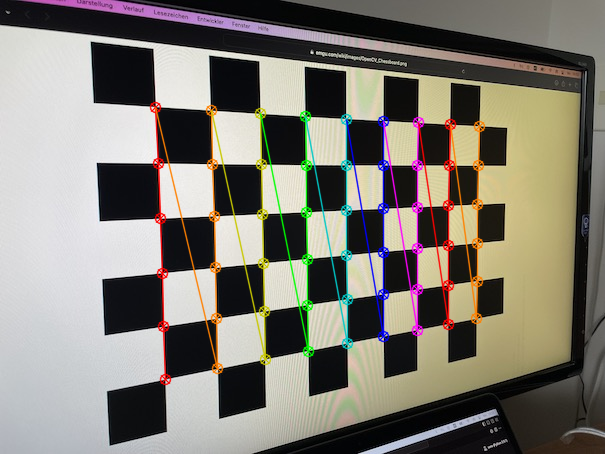

Finding chessboard...
Found board in image 1.


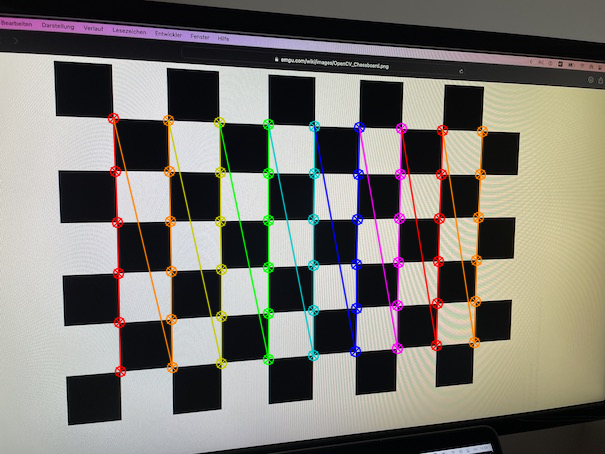

Finding chessboard...
Found board in image 2.


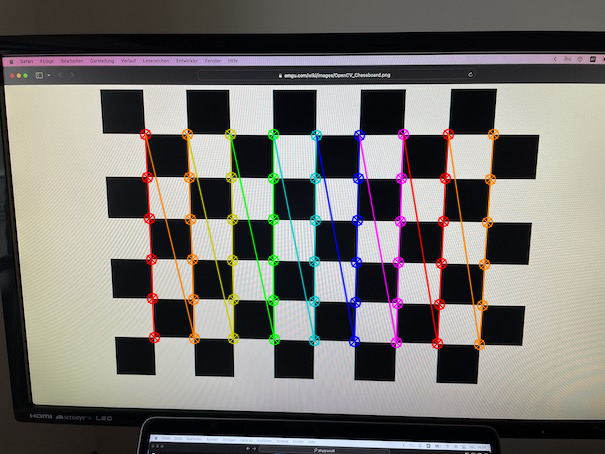

Finding chessboard...
Found board in image 3.


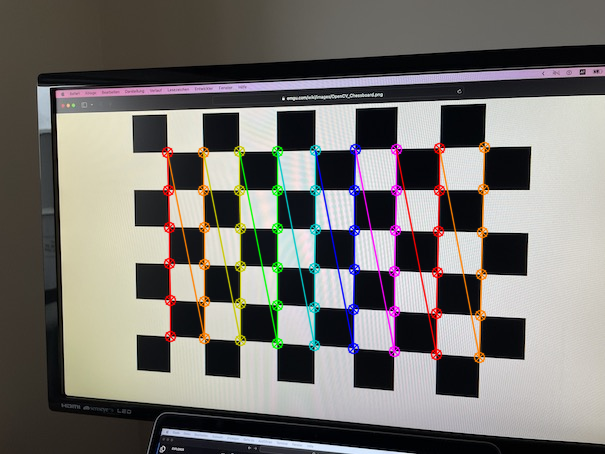

Finding chessboard...
Found board in image 4.


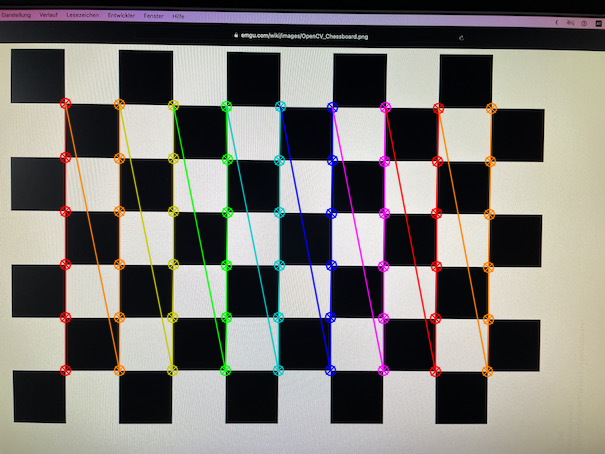

Finding chessboard...
Found board in image 5.


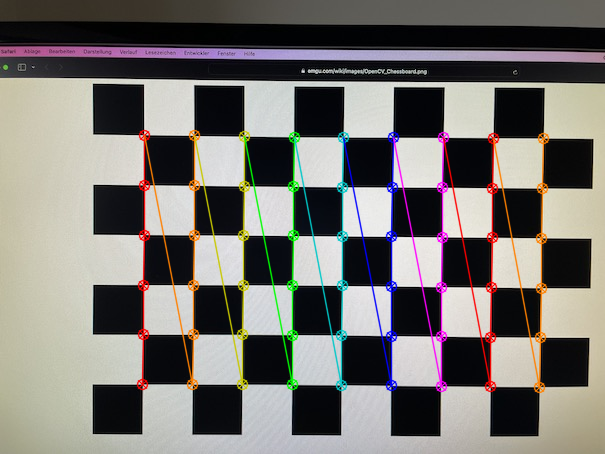

Finding chessboard...
Found board in image 6.


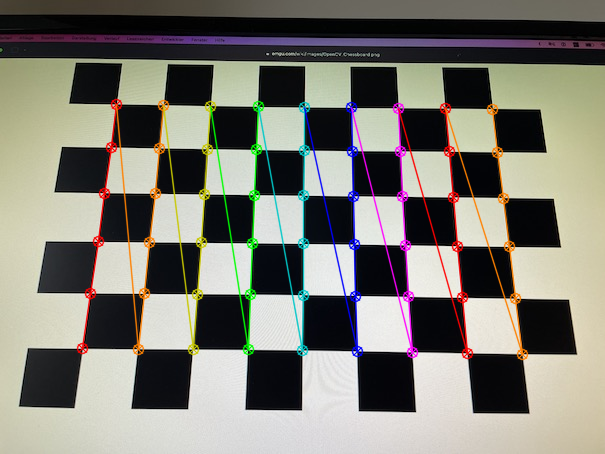

Finding chessboard...
Found board in image 7.


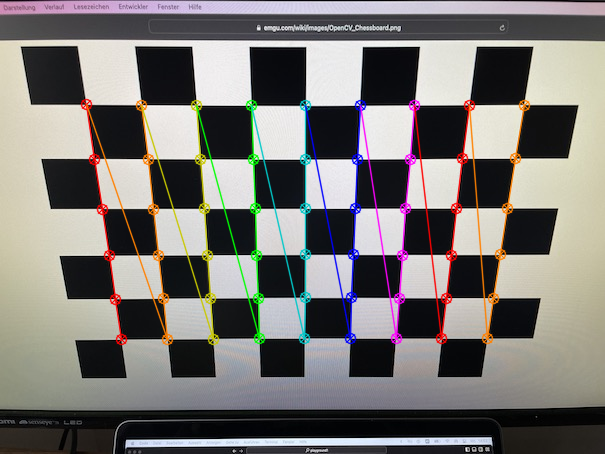

Refined corners in image 0.
Refined corners in image 1.
Refined corners in image 2.
Refined corners in image 3.
Refined corners in image 4.
Refined corners in image 5.
Refined corners in image 6.
Refined corners in image 7.
Calibrating...
Camera Matrix (K):
[[450.27734826   0.         300.01046723]
 [  0.         454.64265379 222.3015285 ]
 [  0.           0.           1.        ]]
k1, k2: 0.24058441467188263 -1.0497828440525918
RMS error: 1.9881305329630266
saved the result to my_params.txt


In [34]:
#@title calibrate_camera.py
ROWS = 6 #@param {type:"integer"}
COLS = 9 #@param {type:"integer"}
CHESS_TXT = 'my_chess.txt' #@param {type:"string"}
OUTPUT_FILENAME = 'my_params.txt' #@param {type:"string"}

import cv2
import numpy as np
import IPython.display
import PIL.Image

import matplotlib.pyplot as plt


def calibrate(images, board_dim = (5,8), debug=True):
    images = np.asarray(images)
    found = []
    image_corners = []
    for count, image in enumerate(images):
        print("Finding chessboard...")
        f, ic = cv2.findChessboardCorners(image, board_dim)
        found.append(f)
        image_corners.append(ic)

        if f:
            print("Found board in image %d." % count)
            if debug:
                tmp = cv2.drawChessboardCorners(image, board_dim, np.squeeze(ic), f)
                IPython.display.display(PIL.Image.fromarray(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB)))
                #cv2.imshow("Detected Chessboard", image)
                #cv2.waitKey()
        else:
            print("NO BOARD in image %d." % count)

    found = np.asarray(found, dtype=bool)
    image_corners = [np.squeeze(crn) for crn in np.array(image_corners)[found]]
    images = images[found]

    crit = (cv2.TERM_CRITERIA_COUNT + cv2.TERM_CRITERIA_EPS, 30, 0.1)
    for img, corners, count in zip(images, image_corners, range(len(images))):
        cv2.cornerSubPix(img.mean(2).astype(np.uint8), corners, (5,5), (-1,-1), crit)
        print("Refined corners in image %d." % count)

    world_corners = np.zeros((np.prod(board_dim), 3), np.float32)
    world_corners[:,:2] = np.indices(board_dim).T.reshape(-1, 2)
    world_corners = [world_corners] * len(image_corners)

    print("Calibrating...")
    rms, K, distortion, rvecs, tvecs = cv2.calibrateCamera(world_corners, image_corners, images[0].shape[:2][::-1], None, None, flags=cv2.CALIB_ZERO_TANGENT_DIST)
    return K, np.squeeze(distortion), rms


##########################

board_dim = (ROWS, COLS)

filenames = [l.strip() for l in open(CHESS_TXT).readlines()]
print(filenames)

images = [cv2.imread(fn) for fn in filenames]

for fn, img in zip(filenames, images):
    if img is None:
        print("Could not load image:", fn)
        exit(1)

K, dist, rms = calibrate(images, board_dim, debug=True)

print("Camera Matrix (K):")
print(K)
print("k1, k2:", dist[0], dist[1])
print("RMS error:", rms)

if len(OUTPUT_FILENAME) > 0:
    params = np.array([K[0,0], dist[0], dist[1]])
    np.savetxt(OUTPUT_FILENAME, params[np.newaxis])
    print('saved the result to %s' % OUTPUT_FILENAME)


# Making Cylindrical Images

The cell `make_cylindrical.py` below  will take images from a calibrated camera and use your completed skeleton (`to_cylindrical()`) to project the images into cylindrical coordinates.

Running the following cell will project the images given in `DESCRIPTION_FILE` into cylindrical coordinates and save them as `FILENAME_cylindrical.EXTENSION` (press `REFRESH` button in the Colab file browser to find the generated files). `DESCRIPTION_FILE` should contain a list of image files, one per line. Later you will add initial translations to this file as well. `CAMERA_PARAMS_FILE` should contain the camera parameters `F`, `k1`, and `k2` on one line, separated by spaces.


['image_1.jpg', 'image_2.jpg', 'image_3.jpg', 'image_4.jpg', 'image_5.jpg', 'image_6.jpg', 'image_7.jpg', 'image_8.jpg', 'image_9.jpg', 'image_10.jpg', 'image_11.jpg', 'image_12.jpg', 'image_13.jpg']
[ 4.50277348e+02  2.40584415e-01 -1.04978284e+00]
Processing 'image_1.jpg' -> 'image_1_cylindrical.jpg' ...


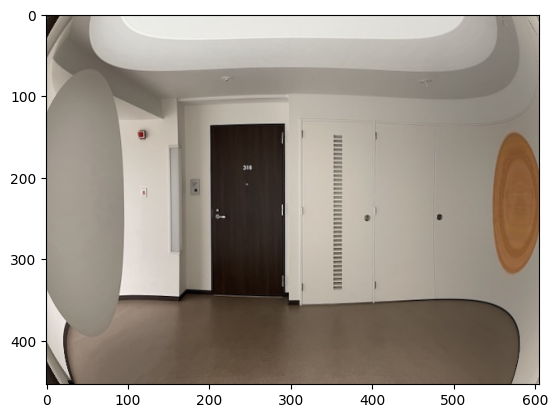

Processing 'image_2.jpg' -> 'image_2_cylindrical.jpg' ...


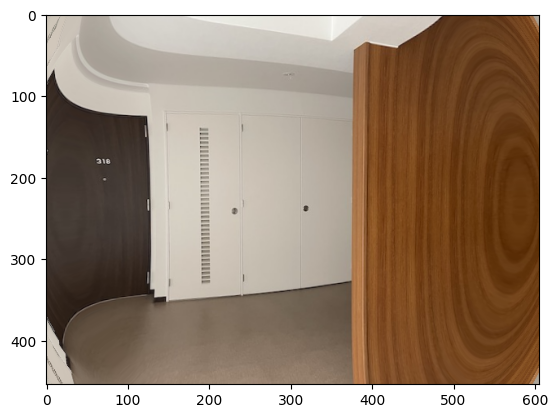

Processing 'image_3.jpg' -> 'image_3_cylindrical.jpg' ...


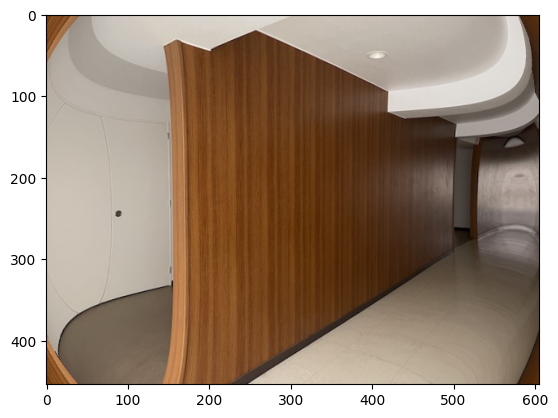

Processing 'image_4.jpg' -> 'image_4_cylindrical.jpg' ...


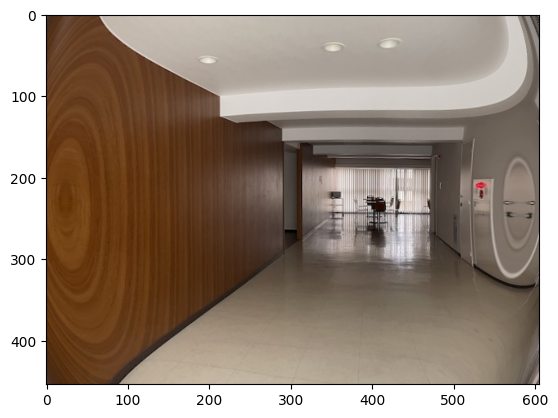

Processing 'image_5.jpg' -> 'image_5_cylindrical.jpg' ...


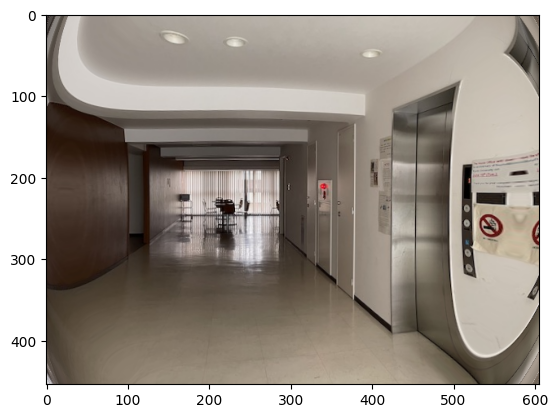

Processing 'image_6.jpg' -> 'image_6_cylindrical.jpg' ...


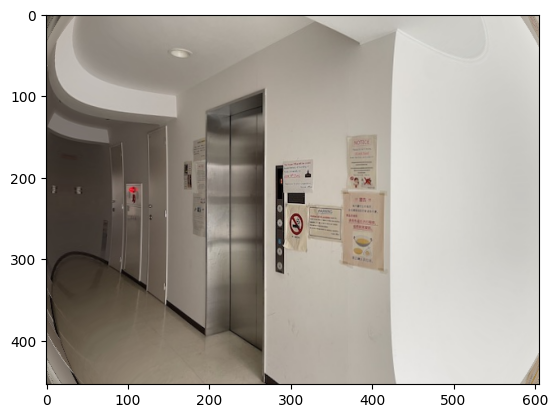

Processing 'image_7.jpg' -> 'image_7_cylindrical.jpg' ...


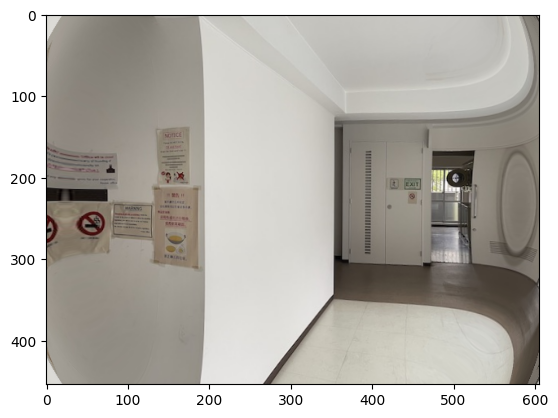

Processing 'image_8.jpg' -> 'image_8_cylindrical.jpg' ...


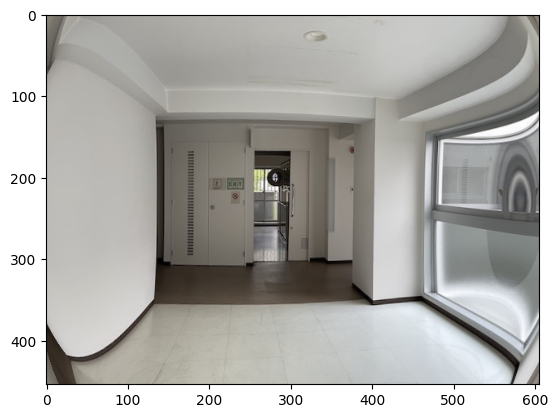

Processing 'image_9.jpg' -> 'image_9_cylindrical.jpg' ...


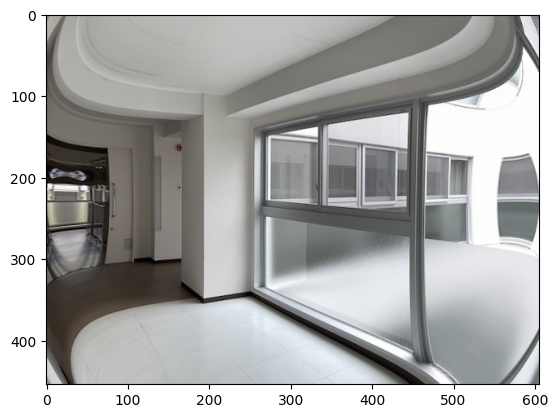

Processing 'image_10.jpg' -> 'image_10_cylindrical.jpg' ...


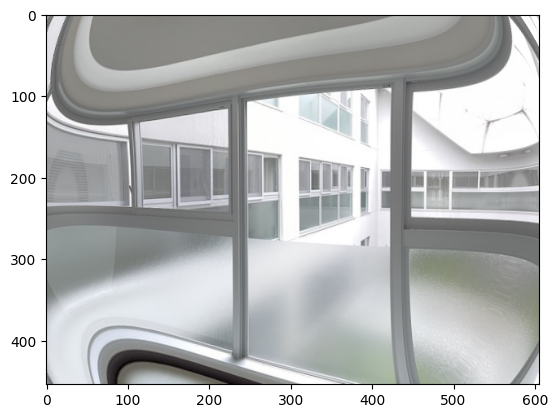

Processing 'image_11.jpg' -> 'image_11_cylindrical.jpg' ...


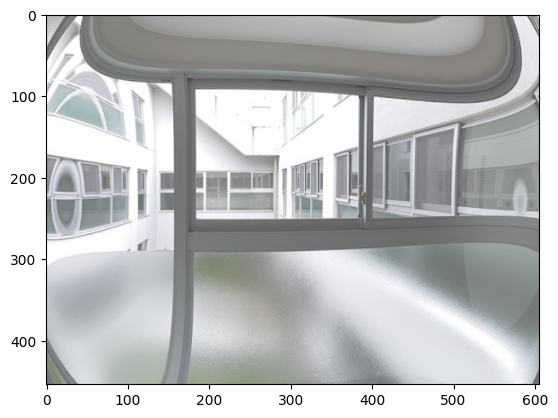

Processing 'image_12.jpg' -> 'image_12_cylindrical.jpg' ...


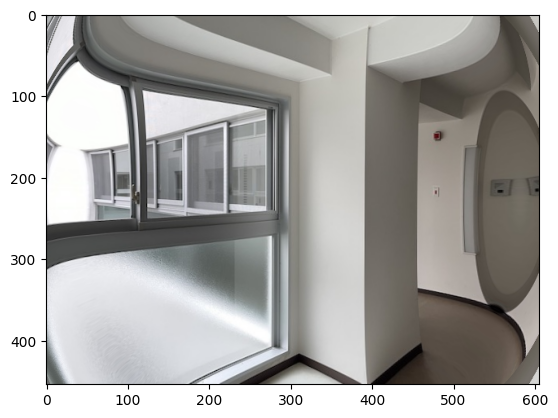

Processing 'image_13.jpg' -> 'image_13_cylindrical.jpg' ...


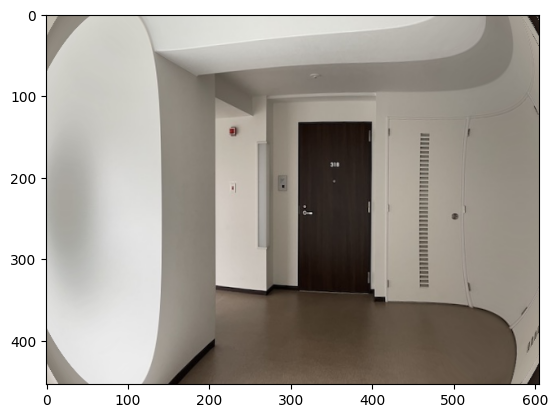

In [35]:
#@title make_cylindrical.py
DESCRIPTION_FILE = 'my_files.txt' #@param {type:"string"}
CAMERA_PARAMS_FILE = 'my_params.txt' #@param {type:"string"}

import numpy as np
#from scipy.misc import *
import cv2
import matplotlib.pyplot as plt

filenames = [l.strip().split()[0] for l in open(DESCRIPTION_FILE).readlines()]
camera_params = np.loadtxt(CAMERA_PARAMS_FILE)

print(filenames)
print(camera_params)

for fn in filenames:
    ext = "." + fn.split(".")[-1]
    cyl_fn = fn.replace(ext, "_cylindrical" + ext)
    print("Processing '%s' -> '%s' ..." % (fn, cyl_fn))
    img = cv2.imread(fn).astype(np.float32) / 255.
    cyl = to_cylindrical(img, camera_params)
    cyl = (cyl*255).astype(np.uint8)
    cv2.imwrite(cyl_fn, cyl)
    plt.imshow(cv2.cvtColor(cyl, cv2.COLOR_BGR2RGB))
    plt.show()


# Making a Panorama

Once you have completed the full skeleton, calibrated your camera (if not using the test images), and created cylindrical image projections, you can take the saved cylindrical images and use a photo editor to manually look up corresponding pixels and compute an initial X/Y translation to roughly align each pair of images in the sequence. The values you put into `DESCRIPTION_FILE` should be X Y translations to align the image on that line with the image that follows it. The last image should have a translation aligning it with the first. Look at the example `test_files.txt` given with the test images as an example.

Once you have filled in the description file (or are using the test images/files), you can run the cell `mosaic.py` below.

It will print out some diagnostic information for each image as it runs your code. This includes the initial displacements, the refined displacements after running your code, the initial image difference (mean absolute pixel difference) and the refined image difference. Since you are aligning the images, the refined difference should be lower than the initial one if your code is working.

The final panorama is saved as `panorama.png`.  Find the file in the Colab file browser and download it if needed.



Refining displacements with Pyramid Iterative Lucas Kanade...
Image 0: [-120.    0.] -> [-68.79566689  -3.86889433]    0.2507 -> 0.2623
Image 1: [-180.    0.] -> [-164.73776771    4.24315822]    0.2177 -> 0.2153
Image 2: [-230.    0.] -> [-306.2341782    -8.21079292]    0.2650 -> 0.3312
Image 3: [-220.    0.] -> [-248.25892719    1.10974777]    0.1969 -> 0.2191
Image 4: [-205.    0.] -> [-203.01086054   -0.64500895]    0.2312 -> 0.2315
Image 5: [-235.    0.] -> [-223.86092795   -8.92850514]    0.2327 -> 0.2355
Image 6: [-235.    0.] -> [-284.30711951   -7.28295951]    0.3073 -> 0.3855
Image 7: [-230.    0.] -> [-276.84614072    1.65296672]    0.3098 -> 0.3721
Image 8: [-205.    0.] -> [-200.48994024   -4.85936551]    0.2803 -> 0.2810
Image 9: [-220.    0.] -> [-2.14431137e+02 -1.53727330e-01]    0.3365 -> 0.3327
Image 10: [-300.    0.] -> [-299.02934626   -1.24632438]    0.4324 -> 0.4317
Image 11: [-290.    0.] -> [-345.6039686   10.1419111]    0.4094 -> 0.4760
Image 12: [-285.    0.] 

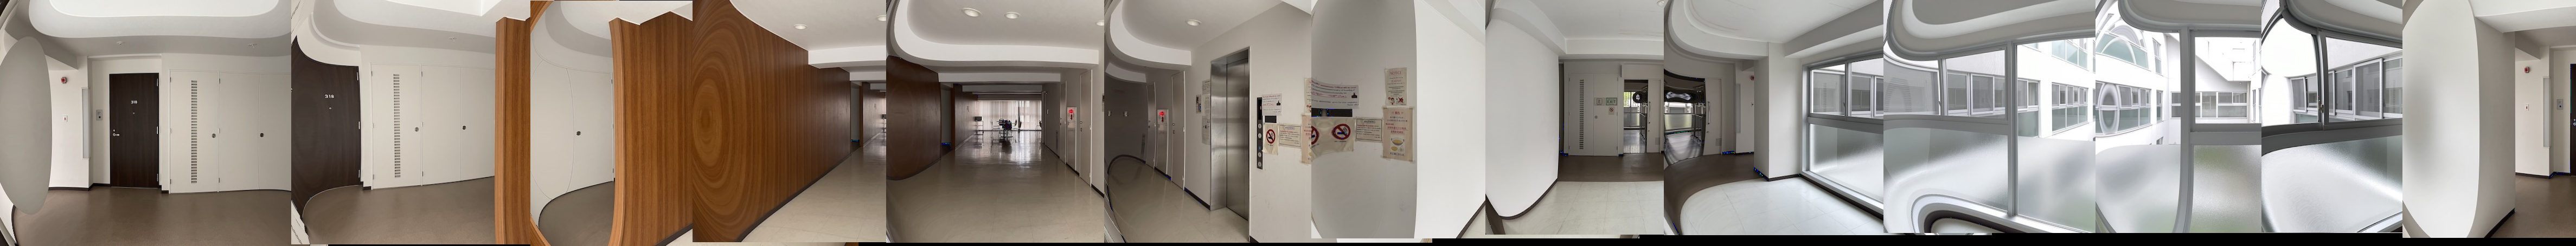

In [48]:
#@title mosaic.py
DESCRIPTION_FILE = 'my_files.txt' #@param {type:"string"}
DOWNLOAD_OUTPUT_FILE = True #@param {type:"boolean"}

import os
import numpy as np
import cv2
import IPython.display
import PIL.Image
#from google.colab import files

filenames, xinit, yinit = zip(*[l.strip().split() for l in open(DESCRIPTION_FILE).readlines()])

cyl_img_fns = []
for fn in filenames:
    ext = "." + fn.split(".")[-1]
    cyl_img_fns.append(fn.replace(ext, "_cylindrical" + ext))
    if not os.path.exists(cyl_img_fns[-1]):
        print("Could not find cylindrical image '%s' for input image '%s'. Did you run make_cylindrical.py yet?" % (cyl_img_fns[-1], fn))
        exit(1)

xinit = np.array([float(x) for x in xinit])[:, np.newaxis]
yinit = np.array([float(y) for y in yinit])[:, np.newaxis]
disps = np.hstack([xinit, yinit])

images = [cv2.imread(fn)[:,:,:3].astype(np.float32)/255. for fn in cyl_img_fns]

panorama = mosaic(images, disps)
panorama = (panorama * 255).astype(np.uint8)
cv2.imwrite('panorama.png', panorama)

IPython.display.display(PIL.Image.fromarray(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)))

#if DOWNLOAD_OUTPUT_FILE:
#    files.download('panorama.png')
